In [5]:
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

In [48]:
def get_character_bounding_boxes(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    output = cv2.connectedComponentsWithStats(
        thresh, 8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    new_stats = []
    added = [False for i in range(len(stats))]
    threshhold = .5
    for i in range(1,len(stats)):
        if added[i]:
            continue

        (xi, yi, wi, hi, ai) = stats[i]
        for j  in range(i+1,len(stats)):
            if added[j]:
                continue

            (xj, yj, wj, hj, aj) = stats[j]
            if xi<=xj:
                if xi+wi>=xj+wj:
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xi+wi>=xj:
                    o = xi+wi-xj
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

            if xj<xi:
                if xj+wj>=xi+wi:
                    xi = xj
                    wi = wj
                    hi = max(yi+hi,yj+hj)
                    yi = min(yi,yj)
                    hi = hi-yi
                    ai += aj
                    added[j] = True
                elif xj+wj>=xi:
                    o = xj+wj-xi
                    if o/wi>threshhold or o/wj>threshhold:
                        wi = xj+wj-xi
                        hi = max(yi+hi,yj+hj)
                        yi = min(yi,yj)
                        hi = hi-yi
                        ai += aj
                        added[j] = True

        new_stats.append([xi, yi, wi, hi, ai])
        added[i] = True

    new_stats = sorted(new_stats, key=lambda x: x[0])
    return new_stats

def extract_bounding_box(img, bounding_box):
    (x, y, w, h, a) = bounding_box
    cropped = img[y:y+h, x:x+w]
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh

In [16]:
num_classes = 17
input_channels = 1
conv_layers = nn.Sequential(
    nn.Conv2d(input_channels, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU()
)

# Calculate the size of the output of the conv_layers by doing one forward pass
dummy_input = torch.randn(1, input_channels, 128, 128)
output = conv_layers(dummy_input)
conv_out = output.shape[1] * output.shape[2] * output.shape[3]

model = nn.Sequential(
    conv_layers,
    nn.Flatten(),
    nn.Linear(conv_out, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

model.load_state_dict(torch.load('models/model8432/model8432.pth'))

<All keys matched successfully>

In [9]:
images_dir = 'handwritten-full-test'
images = [f.path for f in os.scandir(images_dir)]

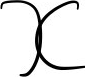

In [13]:
img = images[0]
img = cv2.imread(img)
bbs = get_character_bounding_boxes(img)
Image.fromarray(extract_bounding_box(img, bbs[0]))

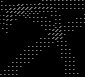

In [50]:
for bb in bbs:
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # thresh = cv2.threshold(gray, 0, 255,
    #     cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    char = extract_bounding_box(img, bb)
    # char = cv2.resize(char, (128, 128))
    # char = cv2.cvtColor(char, cv2.COLOR_BGR2GRAY)
    # char = char / 255
    char = np.expand_dims(char, axis=0)
    char = np.expand_dims(char, axis=0)
    char = torch.from_numpy(char).float()
    # pred = model(char)
    # print(pred.argmax())
    break
Image.fromarray(char[0][0].numpy(), mode='L')

In [26]:
char[0][0]

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9843, 0.9843],
        [0.9882, 0.9922, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
        [0.9725, 0.9843, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])